In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# load data
obesity = pd.read_csv("ObesityDataSet-1.csv")

In [2]:
# collapse the obesity levels into 4 categories
cat_map = {
    'Insufficient_Weight': 'Insufficient Weight',
    'Normal_Weight':      'Normal Weight',
    'Overweight_Level_I':  'Overweight',
    'Overweight_Level_II': 'Overweight',
    'Obesity_Type_I':      'Obese',
    'Obesity_Type_II':     'Obese',
    'Obesity_Type_III':    'Obese'
    }

# apply map to column
obesity['NObeyesdad'] = obesity['NObeyesdad'].map(cat_map)

# finding prevalence
category_counts = obesity['NObeyesdad'].value_counts()

total_count = len(obesity)

prevalence = category_counts / total_count

prevalence_percent = prevalence * 100

print(prevalence_percent)



NObeyesdad
Obese                  46.044529
Overweight             27.475130
Normal Weight          13.595452
Insufficient Weight    12.884889
Name: count, dtype: float64


In [3]:
# Prepare X and y
X = obesity.drop(columns=['Height', 'Weight', 'NObeyesdad'])
y = obesity['NObeyesdad']

# Encode the target
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# Encode the categorical features
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include="object"):
    le_X = LabelEncoder()
    X_encoded[col] = le_X.fit_transform(X_encoded[col])

# Train-Test Split (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y_encoded, train_size=0.80, stratify=y_encoded, random_state=42)
X_tune, X_test, y_tune, y_test = train_test_split(
    X_temp, y_temp, train_size=0.50, stratify=y_temp, random_state=42)

In [4]:
# Grid Search for max_depth
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
scoring = ["precision_macro", "f1_macro", "balanced_accuracy"]
param_grid = {"max_depth": range(1, 11)}

tree = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1
)

# Fit model
grid.fit(X_train, y_train)
best = grid.best_estimator_

print("Best max_depth:", best.get_params()["max_depth"])

Best max_depth: 10


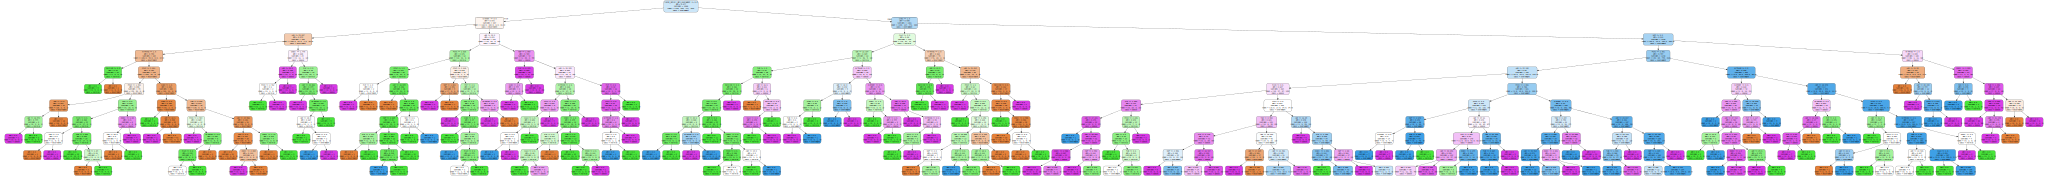

In [5]:
# Plot the best Decision Tree
dot_data = export_graphviz(
    best,
    out_file=None,
    feature_names=X_encoded.columns,
    filled=True,
    rounded=True,
    class_names=['insufficient', 'normal', 'overweight', 'obese']
)
graph = graphviz.Source(dot_data)
graph

In [6]:
# Scores DataFrame
# Collect scores and standard deviations
precision = grid.cv_results_['mean_test_precision_macro']
f1 = grid.cv_results_['mean_test_f1_macro']
bal_acc = grid.cv_results_['mean_test_balanced_accuracy']

SDprecision = grid.cv_results_['std_test_precision_macro']
SDf1 = grid.cv_results_['std_test_f1_macro']
SDbal_acc = grid.cv_results_['std_test_balanced_accuracy']

depth = np.unique(grid.cv_results_['param_max_depth']).data

final_model = pd.DataFrame(
    list(zip(depth, precision, f1, bal_acc, SDprecision, SDf1, SDbal_acc)),
    columns=['depth', 'precision_macro', 'f1_macro', 'balanced_accuracy', 'precisionSD', 'f1SD', 'bal_accSD']
)

final_model.style.hide(axis='index')

depth,precision_macro,f1_macro,balanced_accuracy,precisionSD,f1SD,bal_accSD
1,0.235183,0.290243,0.383417,0.018109,0.023341,0.031918
2,0.479675,0.430898,0.454680,0.078342,0.045314,0.040077
3,0.588848,0.521528,0.533720,0.054859,0.041810,0.035750
4,0.640740,0.556319,0.568740,0.045226,0.034378,0.026839
5,0.647538,0.619133,0.614504,0.039136,0.033632,0.030446
6,0.667070,0.626898,0.623017,0.044447,0.037955,0.034171
7,0.675699,0.656215,0.651632,0.044829,0.041235,0.039326
8,0.684785,0.667681,0.665030,0.032750,0.031619,0.030765
9,0.704212,0.692308,0.689949,0.037031,0.033761,0.032992
10,0.718933,0.709031,0.707457,0.031394,0.031115,0.031913


Tune Set Classification Report:
                     precision    recall  f1-score   support

Insufficient Weight       0.81      0.81      0.81        27
      Normal Weight       0.76      0.55      0.64        29
              Obese       0.80      0.82      0.81        97
         Overweight       0.63      0.69      0.66        58

           accuracy                           0.75       211
          macro avg       0.75      0.72      0.73       211
       weighted avg       0.75      0.75      0.75       211



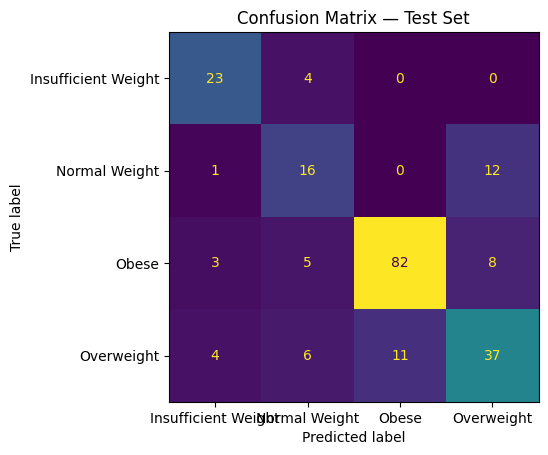

In [9]:
# Tune Set Evaluation
y_tune_pred = best.predict(X_tune)

print("Tune Set Classification Report:")
print(classification_report(y_tune, y_tune_pred, target_names=le_y.classes_))

ConfusionMatrixDisplay.from_estimator(
    best, X_test, y_test,
    display_labels=le_y.classes_,
    colorbar=False
)
plt.title("Confusion Matrix — Test Set")
plt.show()

Top 10 Feature Importances:


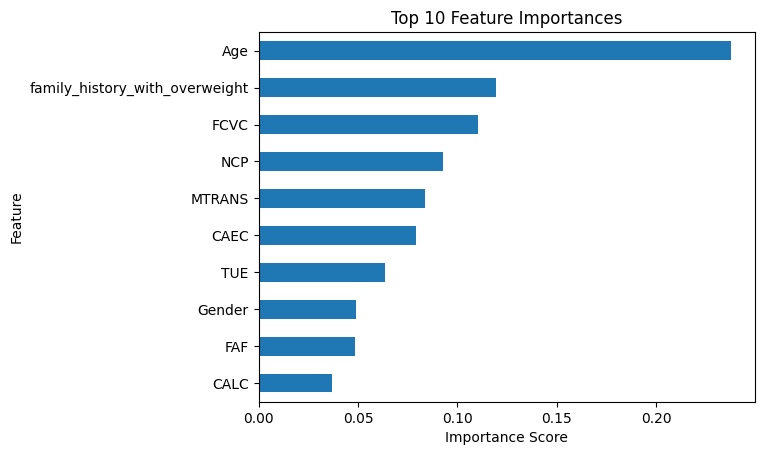

Test Set Classification Report:
                     precision    recall  f1-score   support

Insufficient Weight       0.74      0.85      0.79        27
      Normal Weight       0.52      0.55      0.53        29
              Obese       0.88      0.84      0.86        98
         Overweight       0.65      0.64      0.64        58

           accuracy                           0.75       212
          macro avg       0.70      0.72      0.71       212
       weighted avg       0.75      0.75      0.75       212



In [8]:
# Feature Importances
importances = pd.Series(best.feature_importances_, index=X_encoded.columns)
print("Top 10 Feature Importances:")

# Select top 10 features
top_features = importances.nlargest(10)

# Plot top 10 Feature importances (descending, most important at top)
top_features.sort_values(ascending=False).plot(kind='barh')  # small to big for barh
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Most important at the top
plt.show()

# Final Test Set Evaluation
y_test_pred = best.predict(X_test)

print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le_y.classes_))


